### Cab-Driver Agent

In [1]:
# Importing libraries
import os
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# TODO: Remove this line below for non-AMD GPUs
# AMD GPU
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using plaidml.keras.backend backend.
([1, 20], [(0, 2), [0, 0]])


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix[1,2,:,6]

array([7., 7., 7., 7., 7., 7., 4., 4., 4., 4., 4., 4., 2., 2., 2., 2., 2.,
       2., 8., 8., 8., 8., 8., 8.])

#### Tracking the state-action pairs for checking convergence


In [3]:
track_states = collections.defaultdict(dict)
print(len(track_states))

0


In [4]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        track_states[state][action] = []

In [5]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        discount_factor=0.95,
        learning_rate=0.001,
        epsilon=1,
        epsilon_decay=0.0003,
        epsilon_min=0.00001,
    ):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon_max = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0, 0, 0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        # hidden layers
        model.add(
            Dense(
                32,
                input_dim=self.state_size,
                activation="relu",
                kernel_initializer="he_uniform",
            )
        )
        model.add(Dense(32, activation="relu", kernel_initializer="he_uniform"))

        # the output layer: output is of size num_actions
        model.add(
            Dense(self.action_size, activation="relu", kernel_initializer="he_uniform")
        )

        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # print("action picked from compile model = {}".format(q_value))

            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # print("trying training model")
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)

            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))  # write here

            actions, rewards = [], []

            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(update_input)

                # 2. Get the target for the Q-network
                target_qval = self.model.predict(update_output)

                # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                ### do we need to handle terminal state. termination function here is independent
                #  from actions and state so we can ignore it

                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(
                    target_qval[i]
                )
            # 4. Fit your model and track the loss values
            self.model.fit(
                update_input, target, batch_size=self.batch_size, epochs=1, verbose=0
            )

    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)


In [7]:
Episodes = 20

### DQN block

In [8]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

env = CabDriver()
agent = DQNAgent(
    action_size=len(env.action_space),
    state_size=len(env.state_encod_arch1(env.state_init)),
)
for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    score = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    t = 0
    count = 1
    while not terminal_state:
        count += 1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(
            env.state_encod_arch1(state), env.action_space, possible_actions_index
        )

        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(
            state, action, Time_matrix
        )
        reward = env.reward_func(state, action, Time_matrix)

        # 3. Append the experience to the memory
        agent.append_sample(
            env.state_encod_arch1(state),
            action_index,
            reward,
            env.state_encod_arch1(next_state),
        )

        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        if t >= 24 * 30:
            print("state terminated")
            terminal_state = True

    # Storing total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (
            agent.epsilon_max - agent.epsilon_min
        ) * np.exp(-agent.epsilon_decay * episode)

    # every episode:
    print(
        "episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(
            episode, score, len(agent.memory), agent.epsilon
        )
    )
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        agent.save(name="model.pkl")
        elapsed_time = time.time() - start_time
        print("Total time taken ", elapsed_time)


INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"
state terminated
episode 0, reward -308.0, memory_length 157, epsilon 1.0
Total time taken  11.361975908279419
state terminated
episode 1, reward -304.0, memory_length 289, epsilon 0.9997000479950504
state terminated
episode 2, reward -317.0, memory_length 424, epsilon 0.9994001859622058
state terminated
episode 3, reward -531.0, memory_length 582, epsilon 0.9991004138744786
state terminated
episode 4, reward 170.0, memory_length 732, epsilon 0.9988007317048893
state terminated
episode 5, reward -253.0, memory_length 878, epsilon 0.9985011394264665
state terminated
episode 6, reward -464.0, memory_length 1008, epsilon 0.998201637012247
state terminated
episode 7, reward -173.0, memory_length 1159, epsilon 0.9979022244352754
state terminated
episode 8, reward -145.0, memory_length 1290, epsilon 0.9976029016686048
state terminated
episode 9, reward -560.0, memory_length 1427, epsilon 0.997303668685296
state terminated
episode 10,

In [9]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  194.78272485733032


### Tracking Convergence

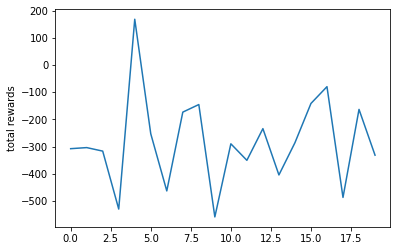

In [10]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [11]:
# Average reward per 100 episodes
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-282.7]


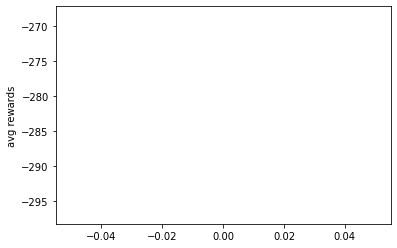

In [12]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

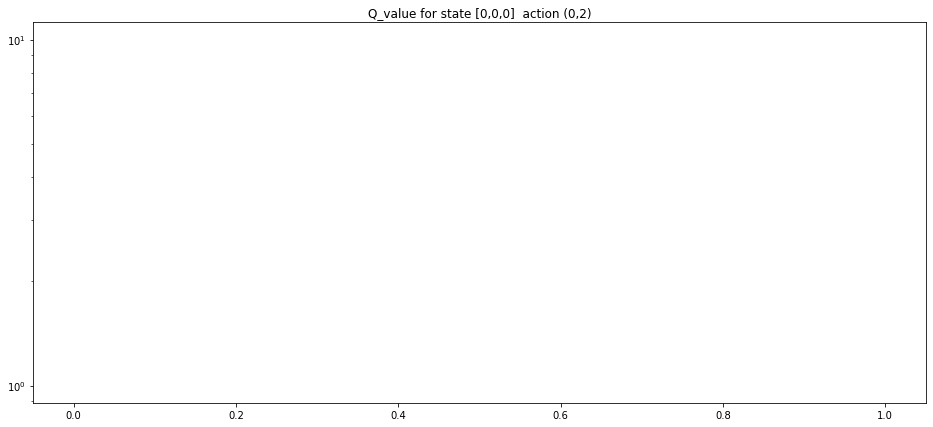

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

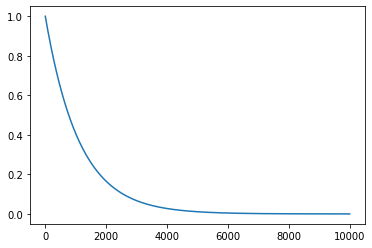

In [15]:
plt.plot(time, epsilon)
plt.show()